# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

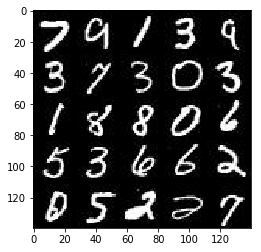

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

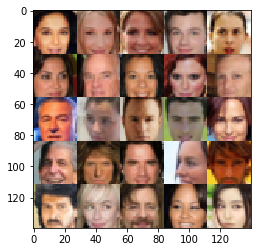

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32,shape= (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return input_images, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        a = 0.2
        conv1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        relu1 = tf.maximum(a * conv1, conv1)

        conv2 = tf.layers.conv2d(relu1, 128, 5, 2, 'SAME')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(a * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, 1, 'SAME')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(a * bn3, bn3)

        flatten = tf.reshape(relu3, (-1, 4*4*256))

        logit = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logit)

        return output, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    a = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 2*2*512)
        fc1 = tf.reshape(fc1, (-1, 2, 2, 512))
        fc1 = tf.maximum(a*fc1, fc1)

        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 5, 2, 'valid')
        bn2 = tf.layers.batch_normalization(deconv2, training=is_train)
        relu2 = tf.maximum(a * bn2, bn2)
        
        deconv3 = tf.layers.conv2d_transpose(relu2, 128, 5, 2, 'SAME')
        bn3 = tf.layers.batch_normalization(deconv3, training=is_train)
        relu3 = tf.maximum(a * bn3, bn3)
        
#         deconv4 = tf.layers.conv2d_transpose(relu3, 64, 3, 2, 'SAME')
#         bn4 = tf.layers.batch_normalization(deconv4, training=is_train)
#         relu4 = tf.maximum(a * bn4, bn4)

        logit = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, 2, 'SAME')
        output = tf.tanh(logit)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gm_out = generator(input_z, out_channel_dim, is_train=True)
    dm_real, dm_out_real = discriminator(input_real, reuse=False)
    dm_false, dm_out_false = discriminator(gm_out, reuse=True)    
    dm_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dm_out_real, 
                                                              labels=tf.ones_like(dm_real)))
    dm_loss_false = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=dm_out_false, 
                                                          labels=tf.zeros_like(dm_false)))
    dm_loss = dm_loss_real + dm_loss_false
    gm_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dm_out_false,
                                                         labels=tf.ones_like(dm_false)))    
    return dm_loss, gm_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_variables = tf.trainable_variables()
    dm_vars = [var for var in train_variables if var.name.startswith('discriminator')]
    gm_vars = [var for var in train_variables if var.name.startswith('generator')]
    dm_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=dm_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        gm_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=gm_vars)

    return dm_opt, gm_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
    input_real, input_z, other = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    dm_loss, gm_loss = model_loss(input_real, input_z, data_shape[3])
    dm_opt, gm_opt = model_opt(dm_loss, gm_loss, learning_rate, beta1)
    
    count = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                count += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(dm_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                sess.run(gm_opt, feed_dict={input_z: batch_z})  
                if count % 20 == 0:
                    train_loss_dm = dm_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_gm = gm_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}---".format(epoch_i+1, epochs),"D-Loss: {:.4f}...".format(train_loss_dm),"G-Loss: {:.4f}".format(train_loss_gm))
                if count % 100 ==0:  
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2--- D-Loss: 1.4212... G-Loss: 0.5482
Epoch 1/2--- D-Loss: 1.2887... G-Loss: 0.6873
Epoch 1/2--- D-Loss: 1.1886... G-Loss: 0.7252
Epoch 1/2--- D-Loss: 1.2641... G-Loss: 0.7079
Epoch 1/2--- D-Loss: 1.1867... G-Loss: 0.7918


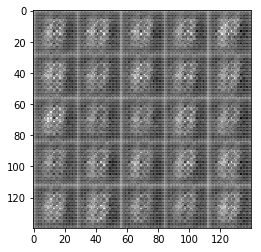

Epoch 1/2--- D-Loss: 1.2738... G-Loss: 0.7509
Epoch 1/2--- D-Loss: 1.2093... G-Loss: 0.7746
Epoch 1/2--- D-Loss: 1.2163... G-Loss: 0.8174
Epoch 1/2--- D-Loss: 1.2074... G-Loss: 0.8279
Epoch 1/2--- D-Loss: 1.2709... G-Loss: 0.7666


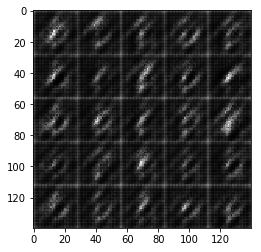

Epoch 1/2--- D-Loss: 1.1860... G-Loss: 0.8121
Epoch 1/2--- D-Loss: 1.1602... G-Loss: 0.8716
Epoch 1/2--- D-Loss: 1.1708... G-Loss: 0.8266
Epoch 1/2--- D-Loss: 1.2416... G-Loss: 0.7608
Epoch 1/2--- D-Loss: 1.1819... G-Loss: 0.7981


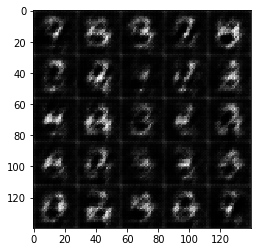

Epoch 1/2--- D-Loss: 1.1321... G-Loss: 0.8459
Epoch 1/2--- D-Loss: 1.0818... G-Loss: 0.8726
Epoch 1/2--- D-Loss: 1.1338... G-Loss: 0.8719
Epoch 1/2--- D-Loss: 1.1521... G-Loss: 0.8528
Epoch 1/2--- D-Loss: 1.1229... G-Loss: 0.8470


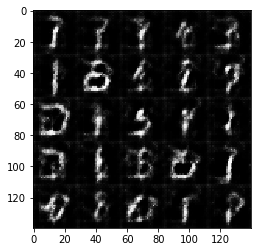

Epoch 1/2--- D-Loss: 1.1739... G-Loss: 0.8222
Epoch 1/2--- D-Loss: 1.1669... G-Loss: 0.8058
Epoch 1/2--- D-Loss: 1.1465... G-Loss: 0.8069
Epoch 1/2--- D-Loss: 1.2357... G-Loss: 0.7683
Epoch 1/2--- D-Loss: 1.1634... G-Loss: 0.7895


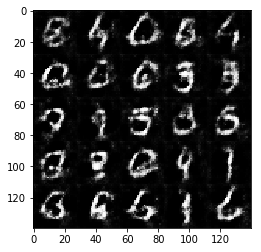

Epoch 1/2--- D-Loss: 1.1134... G-Loss: 0.8592
Epoch 1/2--- D-Loss: 1.1859... G-Loss: 0.8072
Epoch 1/2--- D-Loss: 1.2078... G-Loss: 0.7874
Epoch 1/2--- D-Loss: 1.1789... G-Loss: 0.8045
Epoch 1/2--- D-Loss: 1.1885... G-Loss: 0.8042


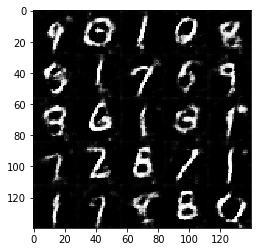

Epoch 1/2--- D-Loss: 1.1748... G-Loss: 0.7880
Epoch 1/2--- D-Loss: 1.2069... G-Loss: 0.8112
Epoch 1/2--- D-Loss: 1.3153... G-Loss: 0.7714
Epoch 1/2--- D-Loss: 1.1766... G-Loss: 0.7950
Epoch 1/2--- D-Loss: 1.2462... G-Loss: 0.7425


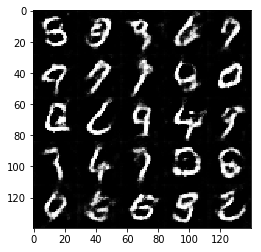

Epoch 1/2--- D-Loss: 1.1994... G-Loss: 0.8116
Epoch 1/2--- D-Loss: 1.2176... G-Loss: 0.8268
Epoch 1/2--- D-Loss: 1.2003... G-Loss: 0.8008
Epoch 1/2--- D-Loss: 1.1450... G-Loss: 0.8530
Epoch 1/2--- D-Loss: 1.2924... G-Loss: 0.8516


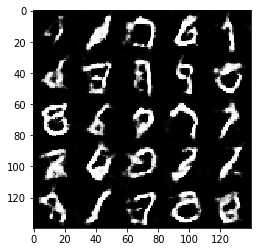

Epoch 1/2--- D-Loss: 1.1658... G-Loss: 0.8226
Epoch 1/2--- D-Loss: 1.1271... G-Loss: 0.8121
Epoch 1/2--- D-Loss: 1.1753... G-Loss: 0.8139
Epoch 1/2--- D-Loss: 1.1681... G-Loss: 0.7933
Epoch 1/2--- D-Loss: 1.1398... G-Loss: 0.8420


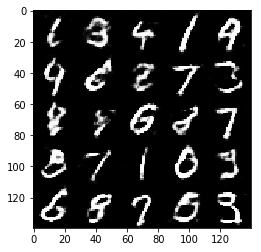

Epoch 1/2--- D-Loss: 1.1276... G-Loss: 0.7976
Epoch 2/2--- D-Loss: 1.2315... G-Loss: 0.7491
Epoch 2/2--- D-Loss: 1.1250... G-Loss: 0.8672
Epoch 2/2--- D-Loss: 1.0347... G-Loss: 0.8793
Epoch 2/2--- D-Loss: 1.1836... G-Loss: 0.7366


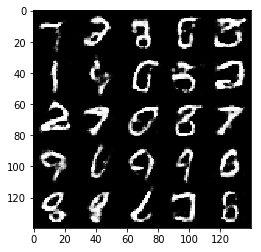

Epoch 2/2--- D-Loss: 1.0590... G-Loss: 0.9022
Epoch 2/2--- D-Loss: 1.1803... G-Loss: 0.7832
Epoch 2/2--- D-Loss: 1.1656... G-Loss: 0.8310
Epoch 2/2--- D-Loss: 1.2270... G-Loss: 0.8146
Epoch 2/2--- D-Loss: 1.0945... G-Loss: 0.8296


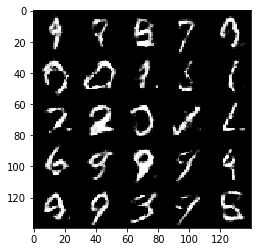

Epoch 2/2--- D-Loss: 1.2369... G-Loss: 0.7334
Epoch 2/2--- D-Loss: 1.2389... G-Loss: 0.7839
Epoch 2/2--- D-Loss: 1.1119... G-Loss: 0.7750
Epoch 2/2--- D-Loss: 1.1220... G-Loss: 0.7849
Epoch 2/2--- D-Loss: 1.1855... G-Loss: 0.7319


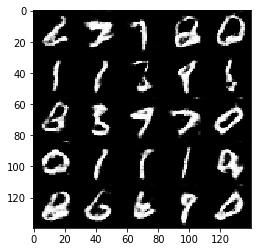

Epoch 2/2--- D-Loss: 1.0647... G-Loss: 0.8216
Epoch 2/2--- D-Loss: 1.1146... G-Loss: 0.7106
Epoch 2/2--- D-Loss: 1.1009... G-Loss: 0.9099
Epoch 2/2--- D-Loss: 1.0668... G-Loss: 1.0279
Epoch 2/2--- D-Loss: 1.1472... G-Loss: 0.6528


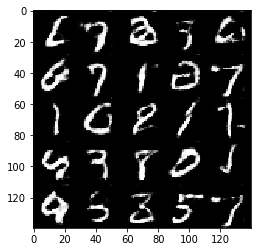

Epoch 2/2--- D-Loss: 1.0165... G-Loss: 0.8339
Epoch 2/2--- D-Loss: 1.0312... G-Loss: 0.8757
Epoch 2/2--- D-Loss: 1.0021... G-Loss: 0.8794
Epoch 2/2--- D-Loss: 1.2468... G-Loss: 0.9707
Epoch 2/2--- D-Loss: 1.0507... G-Loss: 0.8161


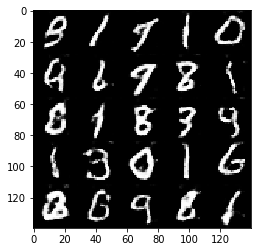

Epoch 2/2--- D-Loss: 0.9890... G-Loss: 0.9833
Epoch 2/2--- D-Loss: 1.1274... G-Loss: 0.7498
Epoch 2/2--- D-Loss: 0.9699... G-Loss: 0.9134
Epoch 2/2--- D-Loss: 1.0103... G-Loss: 0.8209
Epoch 2/2--- D-Loss: 1.0948... G-Loss: 0.6899


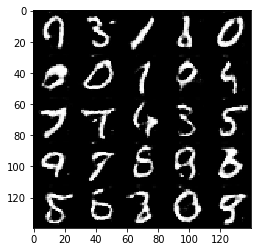

Epoch 2/2--- D-Loss: 1.0452... G-Loss: 0.8272
Epoch 2/2--- D-Loss: 1.1083... G-Loss: 0.9958
Epoch 2/2--- D-Loss: 1.0421... G-Loss: 0.8231
Epoch 2/2--- D-Loss: 0.9206... G-Loss: 1.0659
Epoch 2/2--- D-Loss: 1.0610... G-Loss: 0.9843


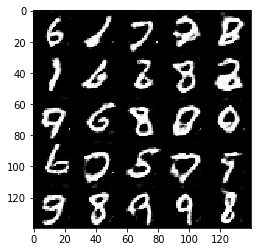

Epoch 2/2--- D-Loss: 1.0689... G-Loss: 1.0097
Epoch 2/2--- D-Loss: 0.9315... G-Loss: 0.9884
Epoch 2/2--- D-Loss: 1.0252... G-Loss: 0.8652
Epoch 2/2--- D-Loss: 0.9714... G-Loss: 0.9791
Epoch 2/2--- D-Loss: 0.9461... G-Loss: 1.0043


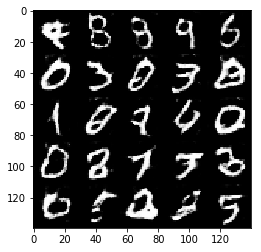

Epoch 2/2--- D-Loss: 0.9850... G-Loss: 0.8115
Epoch 2/2--- D-Loss: 0.9082... G-Loss: 0.9720
Epoch 2/2--- D-Loss: 1.1543... G-Loss: 0.8057
Epoch 2/2--- D-Loss: 0.9096... G-Loss: 0.8775
Epoch 2/2--- D-Loss: 0.9803... G-Loss: 0.9427


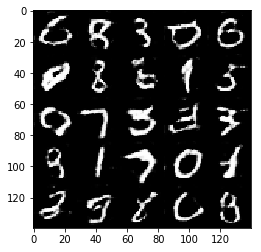

Epoch 2/2--- D-Loss: 1.0444... G-Loss: 0.7467
Epoch 2/2--- D-Loss: 1.0183... G-Loss: 1.0709
Epoch 2/2--- D-Loss: 1.1544... G-Loss: 1.0951


IndexError: list index out of range

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1--- D-Loss: 1.3818... G-Loss: 0.5970
Epoch 1/1--- D-Loss: 0.7979... G-Loss: 1.2121
Epoch 1/1--- D-Loss: 0.5162... G-Loss: 1.4155
Epoch 1/1--- D-Loss: 0.4854... G-Loss: 1.7222
Epoch 1/1--- D-Loss: 0.8723... G-Loss: 2.2109


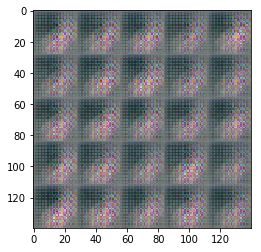

Epoch 1/1--- D-Loss: 0.7473... G-Loss: 1.4343
Epoch 1/1--- D-Loss: 0.3111... G-Loss: 1.9478
Epoch 1/1--- D-Loss: 0.7529... G-Loss: 1.0592
Epoch 1/1--- D-Loss: 1.0088... G-Loss: 1.0663
Epoch 1/1--- D-Loss: 1.4298... G-Loss: 0.4885


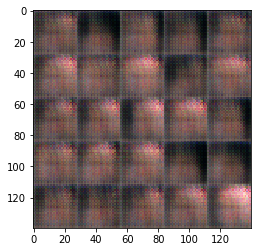

Epoch 1/1--- D-Loss: 1.1282... G-Loss: 0.8582
Epoch 1/1--- D-Loss: 1.2959... G-Loss: 0.8541
Epoch 1/1--- D-Loss: 1.0226... G-Loss: 1.1702
Epoch 1/1--- D-Loss: 0.8876... G-Loss: 1.0834
Epoch 1/1--- D-Loss: 1.2695... G-Loss: 0.9097


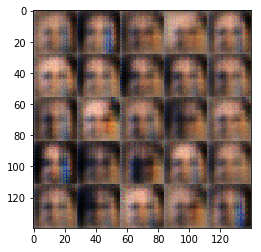

Epoch 1/1--- D-Loss: 0.9866... G-Loss: 1.0583
Epoch 1/1--- D-Loss: 1.3244... G-Loss: 0.9678
Epoch 1/1--- D-Loss: 1.3981... G-Loss: 0.9039
Epoch 1/1--- D-Loss: 1.1356... G-Loss: 0.9393
Epoch 1/1--- D-Loss: 1.2492... G-Loss: 0.8095


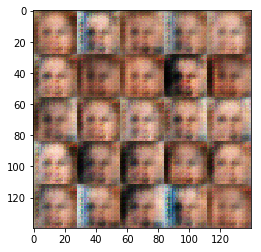

Epoch 1/1--- D-Loss: 1.1360... G-Loss: 0.7690
Epoch 1/1--- D-Loss: 1.3783... G-Loss: 0.7302
Epoch 1/1--- D-Loss: 1.0972... G-Loss: 0.9156
Epoch 1/1--- D-Loss: 1.1159... G-Loss: 1.0453
Epoch 1/1--- D-Loss: 1.0577... G-Loss: 0.8793


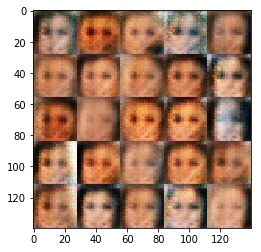

Epoch 1/1--- D-Loss: 1.1805... G-Loss: 0.6125
Epoch 1/1--- D-Loss: 0.9180... G-Loss: 1.0503
Epoch 1/1--- D-Loss: 1.1570... G-Loss: 0.9347
Epoch 1/1--- D-Loss: 1.0960... G-Loss: 0.9889
Epoch 1/1--- D-Loss: 1.0732... G-Loss: 0.8628


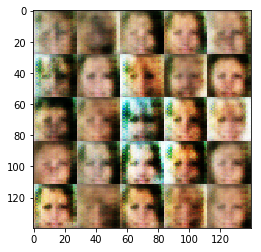

Epoch 1/1--- D-Loss: 1.2090... G-Loss: 0.8978
Epoch 1/1--- D-Loss: 1.2859... G-Loss: 0.7725
Epoch 1/1--- D-Loss: 1.0209... G-Loss: 0.9181
Epoch 1/1--- D-Loss: 1.0683... G-Loss: 0.7951
Epoch 1/1--- D-Loss: 1.1602... G-Loss: 1.0611


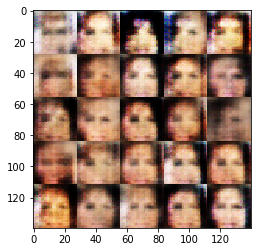

Epoch 1/1--- D-Loss: 1.0353... G-Loss: 1.2430
Epoch 1/1--- D-Loss: 1.1876... G-Loss: 0.7294
Epoch 1/1--- D-Loss: 1.0143... G-Loss: 1.1307
Epoch 1/1--- D-Loss: 1.2230... G-Loss: 0.8727
Epoch 1/1--- D-Loss: 0.9825... G-Loss: 1.0059


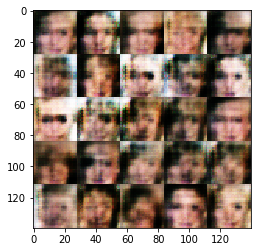

Epoch 1/1--- D-Loss: 1.1142... G-Loss: 0.8007
Epoch 1/1--- D-Loss: 1.0279... G-Loss: 0.9407
Epoch 1/1--- D-Loss: 1.0701... G-Loss: 0.8911
Epoch 1/1--- D-Loss: 1.2163... G-Loss: 0.9201
Epoch 1/1--- D-Loss: 0.9666... G-Loss: 0.9238


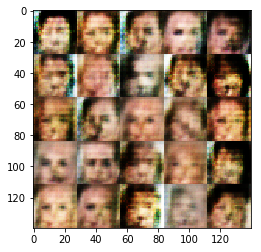

Epoch 1/1--- D-Loss: 1.1477... G-Loss: 0.9295
Epoch 1/1--- D-Loss: 0.9972... G-Loss: 1.0041
Epoch 1/1--- D-Loss: 1.1204... G-Loss: 0.8031
Epoch 1/1--- D-Loss: 1.1307... G-Loss: 0.8391
Epoch 1/1--- D-Loss: 1.0105... G-Loss: 0.8569


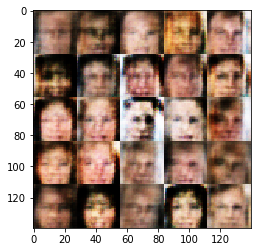

Epoch 1/1--- D-Loss: 1.1958... G-Loss: 0.6935
Epoch 1/1--- D-Loss: 1.1377... G-Loss: 0.8306
Epoch 1/1--- D-Loss: 1.0361... G-Loss: 1.1054
Epoch 1/1--- D-Loss: 1.1882... G-Loss: 0.6882
Epoch 1/1--- D-Loss: 1.1577... G-Loss: 0.8173


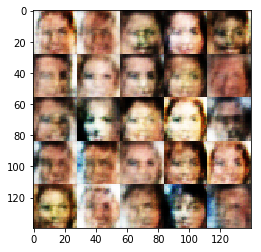

Epoch 1/1--- D-Loss: 0.9228... G-Loss: 1.0531
Epoch 1/1--- D-Loss: 1.2043... G-Loss: 0.8807
Epoch 1/1--- D-Loss: 1.0409... G-Loss: 0.8971
Epoch 1/1--- D-Loss: 1.1545... G-Loss: 0.8830
Epoch 1/1--- D-Loss: 1.0347... G-Loss: 0.8721


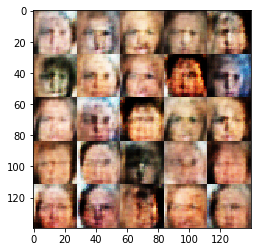

Epoch 1/1--- D-Loss: 0.9197... G-Loss: 1.2412
Epoch 1/1--- D-Loss: 0.9593... G-Loss: 1.0948
Epoch 1/1--- D-Loss: 1.0958... G-Loss: 0.9020
Epoch 1/1--- D-Loss: 0.9365... G-Loss: 1.2792
Epoch 1/1--- D-Loss: 1.0280... G-Loss: 0.9757


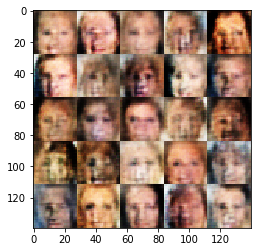

Epoch 1/1--- D-Loss: 1.1749... G-Loss: 0.9446
Epoch 1/1--- D-Loss: 1.0720... G-Loss: 0.9825
Epoch 1/1--- D-Loss: 0.9633... G-Loss: 1.1364
Epoch 1/1--- D-Loss: 0.9301... G-Loss: 1.3708
Epoch 1/1--- D-Loss: 1.1708... G-Loss: 1.0357


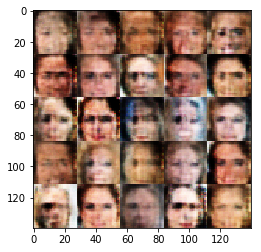

Epoch 1/1--- D-Loss: 0.9480... G-Loss: 0.8786
Epoch 1/1--- D-Loss: 1.1549... G-Loss: 0.8336
Epoch 1/1--- D-Loss: 1.3599... G-Loss: 0.6733
Epoch 1/1--- D-Loss: 0.7281... G-Loss: 1.2608
Epoch 1/1--- D-Loss: 1.0704... G-Loss: 0.9616


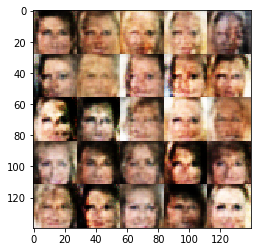

Epoch 1/1--- D-Loss: 1.1502... G-Loss: 0.8411
Epoch 1/1--- D-Loss: 1.0433... G-Loss: 1.0126
Epoch 1/1--- D-Loss: 1.2126... G-Loss: 0.7520
Epoch 1/1--- D-Loss: 1.0757... G-Loss: 1.0143
Epoch 1/1--- D-Loss: 1.0643... G-Loss: 0.7901


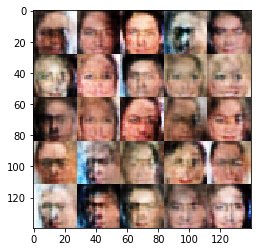

Epoch 1/1--- D-Loss: 0.9662... G-Loss: 1.0460
Epoch 1/1--- D-Loss: 1.1656... G-Loss: 0.7770
Epoch 1/1--- D-Loss: 1.1388... G-Loss: 0.7915
Epoch 1/1--- D-Loss: 1.1780... G-Loss: 0.7323
Epoch 1/1--- D-Loss: 0.8679... G-Loss: 1.1132


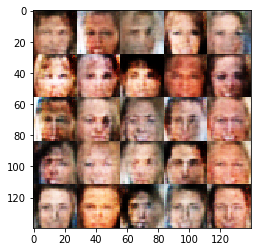

Epoch 1/1--- D-Loss: 1.4502... G-Loss: 0.9370
Epoch 1/1--- D-Loss: 1.2677... G-Loss: 0.6704
Epoch 1/1--- D-Loss: 1.2043... G-Loss: 0.7430
Epoch 1/1--- D-Loss: 1.5783... G-Loss: 0.5644
Epoch 1/1--- D-Loss: 0.8970... G-Loss: 1.1164


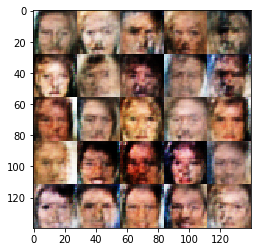

Epoch 1/1--- D-Loss: 1.1344... G-Loss: 0.7964
Epoch 1/1--- D-Loss: 1.2833... G-Loss: 0.5566
Epoch 1/1--- D-Loss: 1.0681... G-Loss: 0.7831
Epoch 1/1--- D-Loss: 1.1901... G-Loss: 0.8631
Epoch 1/1--- D-Loss: 1.0478... G-Loss: 0.8225


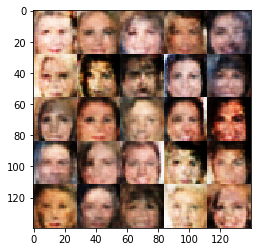

Epoch 1/1--- D-Loss: 1.2435... G-Loss: 0.7251
Epoch 1/1--- D-Loss: 1.2093... G-Loss: 0.9400
Epoch 1/1--- D-Loss: 1.2217... G-Loss: 0.8048
Epoch 1/1--- D-Loss: 1.1223... G-Loss: 0.8915
Epoch 1/1--- D-Loss: 1.3531... G-Loss: 0.7667


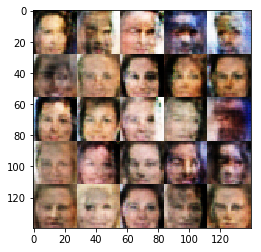

Epoch 1/1--- D-Loss: 1.0193... G-Loss: 1.0197
Epoch 1/1--- D-Loss: 1.3740... G-Loss: 0.7480
Epoch 1/1--- D-Loss: 1.0823... G-Loss: 0.8991
Epoch 1/1--- D-Loss: 1.2907... G-Loss: 0.6940
Epoch 1/1--- D-Loss: 0.8343... G-Loss: 0.8561


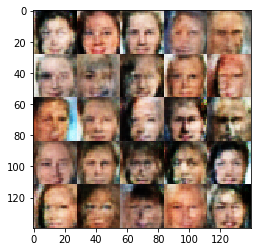

Epoch 1/1--- D-Loss: 1.0193... G-Loss: 1.0360
Epoch 1/1--- D-Loss: 1.3046... G-Loss: 0.7407
Epoch 1/1--- D-Loss: 1.0344... G-Loss: 0.8637
Epoch 1/1--- D-Loss: 1.2963... G-Loss: 0.7930
Epoch 1/1--- D-Loss: 1.4880... G-Loss: 0.8120


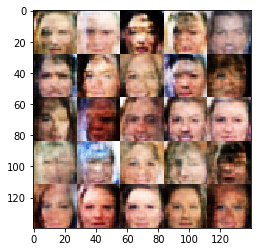

Epoch 1/1--- D-Loss: 1.2799... G-Loss: 0.6994
Epoch 1/1--- D-Loss: 0.9607... G-Loss: 1.4112
Epoch 1/1--- D-Loss: 1.2091... G-Loss: 0.7578
Epoch 1/1--- D-Loss: 1.4197... G-Loss: 0.6651
Epoch 1/1--- D-Loss: 1.1908... G-Loss: 0.8747


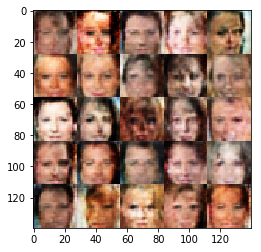

Epoch 1/1--- D-Loss: 1.2314... G-Loss: 0.6858
Epoch 1/1--- D-Loss: 1.4256... G-Loss: 0.8420
Epoch 1/1--- D-Loss: 1.1519... G-Loss: 0.7756
Epoch 1/1--- D-Loss: 0.8641... G-Loss: 0.9941
Epoch 1/1--- D-Loss: 1.0357... G-Loss: 0.8235


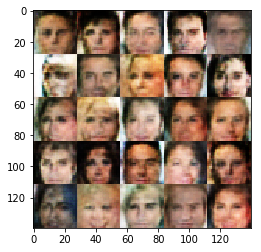

Epoch 1/1--- D-Loss: 1.1804... G-Loss: 0.7658
Epoch 1/1--- D-Loss: 1.2065... G-Loss: 0.8228
Epoch 1/1--- D-Loss: 1.1008... G-Loss: 1.1713
Epoch 1/1--- D-Loss: 1.1395... G-Loss: 0.9264
Epoch 1/1--- D-Loss: 1.0267... G-Loss: 0.8915


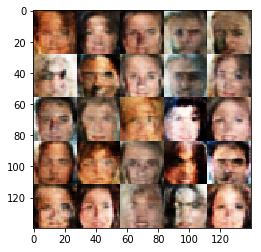

Epoch 1/1--- D-Loss: 1.1629... G-Loss: 0.8062
Epoch 1/1--- D-Loss: 1.1318... G-Loss: 0.8456
Epoch 1/1--- D-Loss: 1.5393... G-Loss: 0.6280
Epoch 1/1--- D-Loss: 1.2497... G-Loss: 0.7498
Epoch 1/1--- D-Loss: 1.0536... G-Loss: 1.0425


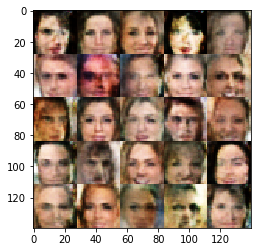

Epoch 1/1--- D-Loss: 1.1677... G-Loss: 0.8865
Epoch 1/1--- D-Loss: 1.1630... G-Loss: 0.8058
Epoch 1/1--- D-Loss: 1.3116... G-Loss: 0.8863
Epoch 1/1--- D-Loss: 1.4146... G-Loss: 0.8230
Epoch 1/1--- D-Loss: 1.3288... G-Loss: 0.6994


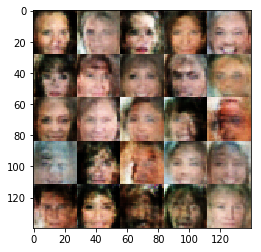

Epoch 1/1--- D-Loss: 1.2591... G-Loss: 0.7770
Epoch 1/1--- D-Loss: 1.2375... G-Loss: 0.7030
Epoch 1/1--- D-Loss: 1.2572... G-Loss: 0.6822
Epoch 1/1--- D-Loss: 1.2092... G-Loss: 0.7658
Epoch 1/1--- D-Loss: 1.2907... G-Loss: 0.6720


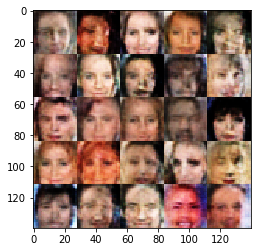

Epoch 1/1--- D-Loss: 1.2921... G-Loss: 0.6571
Epoch 1/1--- D-Loss: 1.1723... G-Loss: 1.0640
Epoch 1/1--- D-Loss: 1.2229... G-Loss: 0.7942
Epoch 1/1--- D-Loss: 1.3288... G-Loss: 0.6415
Epoch 1/1--- D-Loss: 1.1713... G-Loss: 0.7761


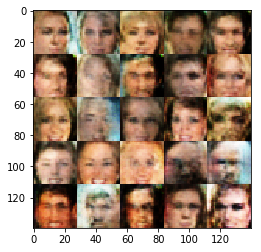

Epoch 1/1--- D-Loss: 1.3605... G-Loss: 0.6653
Epoch 1/1--- D-Loss: 1.1518... G-Loss: 0.8528
Epoch 1/1--- D-Loss: 1.1182... G-Loss: 0.7354
Epoch 1/1--- D-Loss: 1.2902... G-Loss: 0.8036
Epoch 1/1--- D-Loss: 1.0573... G-Loss: 0.8818


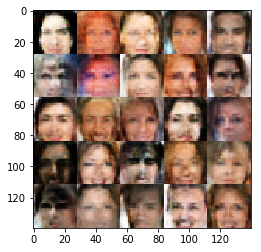

Epoch 1/1--- D-Loss: 1.3517... G-Loss: 0.6782
Epoch 1/1--- D-Loss: 1.3391... G-Loss: 0.9590
Epoch 1/1--- D-Loss: 1.1950... G-Loss: 0.8504
Epoch 1/1--- D-Loss: 1.1590... G-Loss: 0.8367
Epoch 1/1--- D-Loss: 1.1333... G-Loss: 0.8109


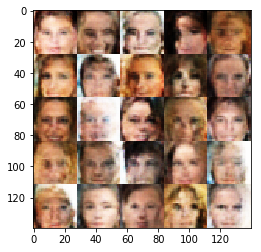

Epoch 1/1--- D-Loss: 1.1111... G-Loss: 0.8500
Epoch 1/1--- D-Loss: 1.3256... G-Loss: 0.6746
Epoch 1/1--- D-Loss: 1.1012... G-Loss: 0.8519


IndexError: list index out of range

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.